In [1]:
# 首先用来生成一些历史数据 每一条表示 一系列的s和a
import numpy as np
import time
import math
import sympy as sp
import random
def policy(st,mu_a_t,mu_s_t,matrix_p_t):
    at = mu_a_t+ np.dot(matrix_p_t, st-mu_s_t)
    return at

def reward(mt,bt,ct,at,st):
    rt = mt + np.dot(bt,at)+ np.dot(ct,st)
    return rt

def f(st,at,mu_s_t1,mu_s_t,mu_a_t,beta_s_t, beta_a_t):
    #print(beta_a_t)
    s_t1 = mu_s_t1 + np.dot(beta_s_t, st-mu_s_t) + np.dot(beta_a_t, at-mu_a_t)
    #print(st-mu_s_t)
    #print(beta_s_t)
    return s_t1

def simulate_begin(e):
    for t in range(1, T):
        a[t] = policy(s[t], mu_a[t], mu_s[t], matrix_p[t])
        if t + 1 < T:
            s[t + 1] = f(s[t], a[t], mu_s[t + 1], mu_s[t], mu_a[t], beta_s[t], beta_a[t]) + e[t-1]
        r[t] = reward(m_fix[t], b[t], c[t], a[t], s[t])
        R[t] = R[t - 1] + r[t]
    return R[T - 1]


T = 4
# 一共有T-1期，参与了T-2个factor（第0期不考虑）
num_e = T - 2
num_s = 3
num_a = 1

m_fix = np.ones(T)
m_fix = m_fix / 1
b = np.ones((T, num_a))
b = b / 1

c = np.ones((T, num_s))


matrix_p = 0.1*np.ones((T, num_a, num_s))


mu_s = np.random.normal(0.5, 0, size=(T, num_s))
mu_a = np.random.normal(0.5, 0, size=T)


beta_s = 0.5*np.ones((T, num_s, num_s))
beta_a = 0.5*np.ones((T, num_s))
for t in range(1,3):
    beta_s[t][1] = 1*np.array([0.6,0.6,0.6])
    beta_s[t][2] = 1*np.array([0.7,0.7,0.7])
    beta_a[t] = 1*np.array([0.5,0.6,0.7])

a_record = np.zeros(3)
s_record = np.zeros((3,3))

n_size = 20
a_final = np.zeros((n_size,3))
s_final = np.zeros((n_size,3,3)) # 第一个维数就是时间t

np.random.seed(0)

for i in range(n_size):
    R = np.zeros(T)
    r = np.zeros(T)
    s = np.zeros((T, num_s))
    a = np.zeros(T)
    # 确定性的参数部分
    # 这里假设s1来自于一个正态
    s[1] = np.random.normal(1, 0.1, size=3)
    e = np.random.normal(loc = 0 , scale = 0.1,size = 2)
    final_reward = simulate_begin(e)
    for j in range(3):
        a_record[j] = a[j+1]
        for k in range(3):
            s_record[j][k] = s[j+1][k]
    a_final[i] = a_record
    s_final[i] = s_record


np.random.seed(1)
prior_beta = np.random.normal(0.6, 0.1, size = 3) # 一共两期beta



# 记录关于beta的样本序列，我们这里只关心3个beta
period = 900
beta_sample = np.zeros((period,3))
beta_sample[0] = prior_beta
a_sample = beta_a[1] 


# 这是先验分布的标准差和均值
delta = 0.1
beta_0 = 0.6

v = 0.1

def sample_of_beta(subset):
    global s_final,prior_beta,period
    subset_size = len(subset)
    s_final_subset = s_final[subset]
    a_final_subset = a_final[subset]

    alpha_1 = np.zeros(subset_size)
    alpha_2 = np.zeros(subset_size)
    alpha_3 = np.zeros(subset_size)
    for i in range(subset_size):
        alpha_1[i] = s_final_subset[i][0][0] - mu_s[0][0]
        alpha_2[i] = s_final_subset[i][0][1] - mu_s[0][1]
        alpha_3[i] = s_final_subset[i][0][2] - mu_s[0][2]
    
    beta_sample = np.zeros((period,3))
    beta_sample[0] = prior_beta

    for t in range(period-1):
        m_11 = np.zeros(subset_size)
        for i in range(subset_size):
            m_11[i] = s_final_subset[i][1][0] - mu_s[1][0] - \
            beta_sample[t][1]*(s_final_subset[i][0][1] - mu_s[0][1]) - beta_sample[t][2]*(s_final_subset[i][0][2] - mu_s[0][2]) -\
            a_sample[0]*(a_final_subset[i][0] - mu_a[0])

        wide_beta = (delta**2*np.sum(alpha_1*m_11) + v**2*beta_0)/(delta**2*np.sum(alpha_1**2) + v**2)
        wide_delta2 = (delta**2*(v**2))/(delta**2*np.sum(alpha_1**2) + v**2)

        beta_sample[t+1][0] = np.random.normal(wide_beta, scale = np.sqrt(wide_delta2), size = 1)

        m_21 = np.zeros(subset_size)
        for i in range(subset_size):
            m_21[i] = s_final_subset[i][1][0] - mu_s[1][0] - \
            beta_sample[t+1][0]*(s_final_subset[i][0][0] - mu_s[0][0]) - beta_sample[t][2]*(s_final_subset[i][0][2] - mu_s[0][2])-\
            a_sample[0]*(a_final_subset[i][0] - mu_a[0])  

        wide_beta = (delta**2*np.sum(alpha_2*m_21) + v**2*beta_0)/(delta**2*np.sum(alpha_2**2) + v**2)
        wide_delta2 = (delta**2*(v**2))/(delta**2*np.sum(alpha_2**2) + v**2)
        beta_sample[t+1][1] = np.random.normal(wide_beta, scale = np.sqrt(wide_delta2), size = 1)

        m_31 = np.zeros(subset_size)
        for i in range(subset_size):
            m_31[i] = s_final[i][1][0] - mu_s[1][0] - \
            beta_sample[t+1][0]*(s_final_subset[i][0][0] - mu_s[0][0]) - beta_sample[t+1][1]*(s_final_subset[i][0][1] - mu_s[0][1])-\
            a_sample[0]*(a_final_subset[i][0] - mu_a[0])  

        wide_beta = (delta**2*np.sum(alpha_3*m_31) + v**2*beta_0)/(delta**2*np.sum(alpha_3**2) + v**2)
        wide_delta2 = (delta**2*(v**2))/(delta**2*np.sum(alpha_3**2) + v**2)
        beta_sample[t+1][2] = np.random.normal(wide_beta, scale = np.sqrt(wide_delta2), size = 1)
    return beta_sample[10:]

np.random.seed(2)
for i in range(5):
    s_final[i][0] += np.random.normal(0, scale = 0.1, size = 3)
    s_final[i][1] += np.random.normal(0, scale = 0.1, size = 3)
for i in range(5,n_size):
    s_final[i][0] += np.random.normal(0, scale = 0.5, size = 3)
    s_final[i][1] += np.random.normal(0, scale = 0.5, size = 3)
    
# 调整
s_final[9] = s_final[16]
s_final[7] = s_final[16]
s_final[17] = s_final[16]
s_final[0] = s_final[1]
s_final[12] = s_final[11]

In [2]:
import numpy as np
import time
import math
import sympy as sp
import random
from itertools import permutations
from multiprocessing import Pool, freeze_support
from scipy.stats import invgamma
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans



def P(perm, i):
    m_index = perm.index(i)
    if m_index > 0:
        # 切片，选择前面的所有元素
        ele_list = list(perm[0:m_index])
        return ele_list
    else:
        return list()

def simulate_data(e,sample_1):
    beta_s[1][0] = sample_1
    beta_s[2][0] = sample_1
    for t in range(1, T):
        a[t] = policy(s[t], mu_a[t], mu_s[t], matrix_p[t])
        if t + 1 < T:
            s[t + 1] = f(s[t], a[t], mu_s[t + 1], mu_s[t], mu_a[t], beta_s[t], beta_a[t]) + e[t-1]
        r[t] = reward(m_fix[t], b[t], c[t], a[t], s[t])
        R[t] = R[t - 1] + r[t]
    return R[T - 1]


def g_hat(subset):
    if len(subset) == 0:
        return 0
    else:
        sample_list = sample_of_beta(subset)
        pos_value = np.zeros(period-10)
        for i in range(period-10):
            e = np.random.normal(loc = 0 , scale = 0.1,size = 2)
            pos_value[i] = simulate_data(e,sample_list[i])
        res = 1.3796- np.var(pos_value, ddof =1) # 1.3796 c=1
        return res

def generate_random_order(num):
    # 生成0到99的整数列表
    numbers = list(range(num))
    # 随机打乱列表
    random.shuffle(numbers)
    return numbers



n_size = 20

R = np.zeros(T)
r = np.zeros(T)
s = np.zeros((T, num_s))
s[1] = np.random.normal(1, 0.1, size=3)
a = np.zeros(T)

'''
ss = 50000
pri_value = np.zeros(ss)
prior = np.random.normal(loc = beta_0, scale = delta, size = (ss,3))
for i in range(ss):
    e = np.random.normal(loc = 0 , scale = 0.1,size = 2)
    pri_value[i] = simulate_data(e, prior[i])
print(np.var(pri_value, ddof =1))
'''

'\nss = 50000\npri_value = np.zeros(ss)\nprior = np.random.normal(loc = beta_0, scale = delta, size = (ss,3))\nfor i in range(ss):\n    e = np.random.normal(loc = 0 , scale = 0.1,size = 2)\n    pri_value[i] = simulate_data(e, prior[i])\nprint(np.var(pri_value, ddof =1))\n'

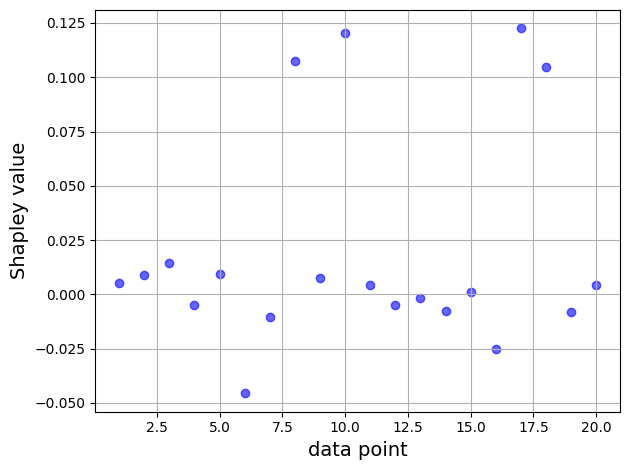

running time: 2755.7807071208954
[ 0.00506078  0.0088613   0.01441825 -0.00477326  0.00948239 -0.04561274
 -0.01035452  0.1075796   0.00735499  0.12048207  0.00420056 -0.00509863
 -0.00147665 -0.00749576  0.00133032 -0.02498284  0.12256735  0.10462888
 -0.00810941  0.00431674]


In [3]:
s_time = time.time()
pm = 500
Sh = np.zeros(n_size)
for _ in range(pm):
    perm = generate_random_order(n_size)
    for i in range(n_size):
        Sh[i] = Sh[i] + g_hat(P(perm,i)+[i]) - g_hat(P(perm,i))
Sh = Sh/pm

x_values = list(range(1,n_size+1))
y_values = Sh
plt.scatter(x_values, y_values, color='blue', alpha=0.6)

# 设置标题和标签
#plt.title('Scatter Plot of Random Data')
plt.xlabel('data point',fontsize=14)
plt.ylabel('Shapley value',fontsize=14)


# 显示图形
plt.grid()
plt.tight_layout()
#plt.savefig('est_Sh.png', bbox_inches='tight', dpi=300)
plt.show()

e_time = time.time()
print('running time:', e_time-s_time)
print(Sh)